# **Assignment 5**
# **Sunspots – magnetic field and temperature structure. Part I.**

### **Data Analysis for Space Weather | Instructor: Prof Podladchikova | April, 2021**
### **by Victoria Krivova, Polina Starodumova**

In [544]:
# Firstly, we install SunPy package
# !pip install sunpy

In [583]:
# After that, we import several libraries which will be used during the assignment implementation 
from astropy.io import fits
from astropy import units as u

In [610]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import math
# from google.colab import files
import scipy.stats as stats
import matplotlib.mlab as mlab

In [611]:
import sunpy
import sunpy.map

In [612]:
# In the original Astropy package of units, there is no angstrom, however, it will be needed for FITS files to work 
# correctly, so we deifine the unit by ourselves
ANG = u.def_unit('ANG', 10**(-10) * u.m)
u.add_enabled_units([ANG]);

In [613]:
# Since we are working in Google Colab, we need to use the following function to upload the datasets
# uploaded = files.upload()

In [614]:
# Continuum image of the Sun
data_1, header_1 = sunpy.io.fits.read('hmi.Ic_720s.20141219_230000_TAI.1.continuum_cal.fits')[0]
map_1 = sunpy.map.Map(data_1, header_1)

In [615]:
# Image of the line-of-site (LOS) magnetic field flux density
data_2, header_2 = sunpy.io.fits.read('hmi.M_720s.20141219_230000_TAI.1.magnetogram_cal.fits')[0]
map_2 = sunpy.map.Map(data_2, header_2)

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


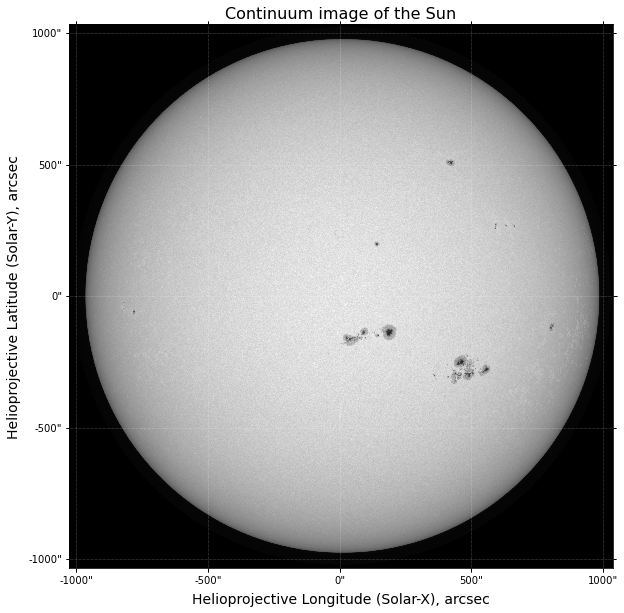

In [616]:
fig = plt.figure(figsize=(10,10))
map_1.plot()

title_font = {'size':'16'}
axis_font = {'size':'14'}

plt.xlabel("Helioprojective Longitude (Solar-X), arcsec", **axis_font)
plt.ylabel("Helioprojective Latitude (Solar-Y), arcsec", **axis_font)
plt.title("Continuum image of the Sun", **title_font)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show();

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


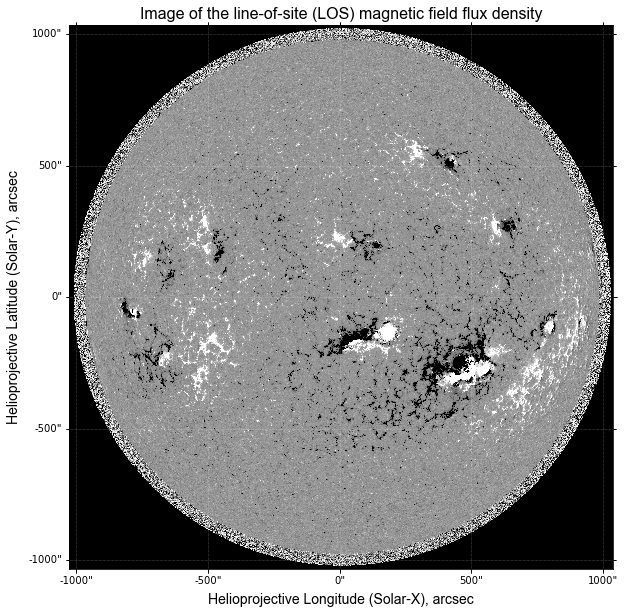

In [617]:
fig = plt.figure(figsize=(10,10))
map_2.plot(cmap='Greys_r', norm=colors.Normalize(vmin=-100, vmax=100))

title_font = {'fontname':'Arial', 'size':'16'}
axis_font = {'fontname':'Arial', 'size':'14'}

plt.xlabel("Helioprojective Longitude (Solar-X), arcsec", **axis_font)
plt.ylabel("Helioprojective Latitude (Solar-Y), arcsec", **axis_font)
plt.title("Image of the line-of-site (LOS) magnetic field flux density", 
          **title_font)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show();

**On the first image, one may find several sunspots, while the second image provide with the information regarding the line-of-site magnetic field fluxes. Moreover, on the second picture it is clarly seen that the sunspots show a double structure with opposite magnetic polarities. If one mentally "combine" the two images and look at the areas of sunspots on both Southern and Northern hemispheres, one may notice that all preceding (p) spots in one hemisphere have the same polarity, and all following (f) spots have the opposite polarity, however, in the other hemisphere, the polarities are opposite (!) - it is observed by looking at how the colors change on the second picture in comparison with the sunspot locations from the first image.**

In [618]:
# Let us extract the field of interest with the sunspot from the southern hemisphere
a = 2335
b = 2500
c = 1700
d = 1870

In [619]:
data_1_sunspot = data_1[c:d, a:b]
map_1_sunspot = sunpy.map.Map(data_1_sunspot, header_1)

data_2_sunspot = data_2[c:d, a:b]
map_2_sunspot = sunpy.map.Map(data_2_sunspot, header_1)

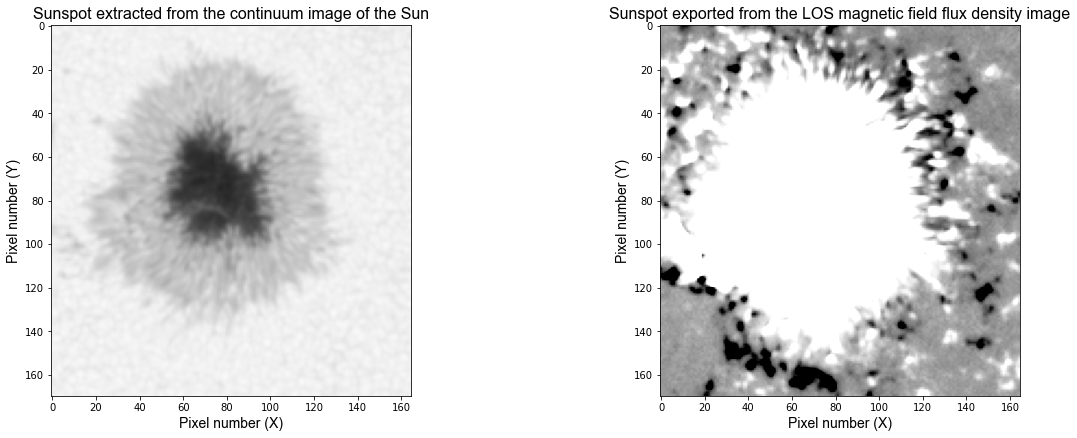

In [620]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,2,1)

ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data_1_sunspot, cmap='Greys_r', norm=colors.Normalize(vmin=0, vmax=64000))
ax1.set_title('Sunspot extracted from the continuum image of the Sun', **title_font)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(data_2_sunspot, cmap='Greys_r', norm=colors.Normalize(vmin=-100, vmax=100))
ax2.set_title('Sunspot exported from the LOS magnetic field flux density image', **title_font);

**In the following part of the assignment, we will be working with these subsets of one sunspot from the Southern hemisphere only. Now, let us obtain the distrubution of the intensity on the continuum sun image as well as the distribution of the magnetic field flux values on the given subsets - it will help us to understand how to define thresholds in future tasks where we need to extract umbra and penumbra of the sunspot:**

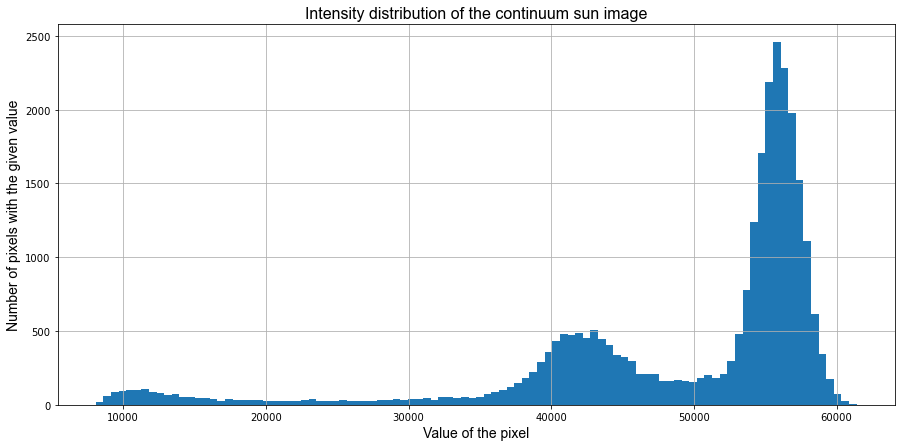

In [621]:
fig = plt.figure(figsize=(15,7))
counts, bins = np.histogram(data_1_sunspot, bins = 100)
plt.hist(bins[:-1], bins,  weights=counts)
plt.xlabel("Value of the pixel", **axis_font)
plt.ylabel("Number of pixels with the given value", **axis_font)
plt.title("Intensity distribution of the continuum sun image", **title_font)
plt.grid();

**From the histogram, one may see that the majority of the pixels have values higher than 50,000 units. A peak of approximately 500 pixels with values of around 42,000 units is observed to the left of the major peak.**

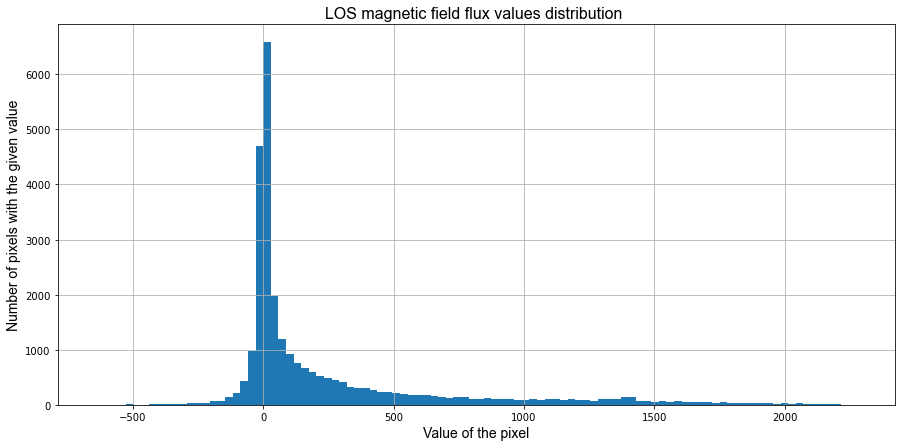

In [622]:
fig = plt.figure(figsize=(15,7))
counts, bins = np.histogram(data_2_sunspot, bins=100)
plt.hist(bins[:-1], bins,  weights=counts)
plt.xlabel("Value of the pixel", **axis_font)
plt.ylabel("Number of pixels with the given value", **axis_font)
plt.title("LOS magnetic field flux values distribution ", **title_font)
plt.grid();

In [623]:
print('The minimum value of the magnetic field flux is', data_2_sunspot.min(), 
      'G, while the maximum value is', data_2_sunspot.max(), 'G.')

The minimum value of the magnetic field flux is -641.8 G, while the maximum value is 2275.3 G.


**From the histogram, it is seen that the values of the magnetic field flux are concentrated around zero, there are both positive and negative values though. For convenience, we will move the distribution to have the initial point at zero:**

In [624]:
data_2_sunspot = data_2_sunspot - data_2_sunspot.min()
map_2_sunspot = sunpy.map.Map(data_2_sunspot, header_1)

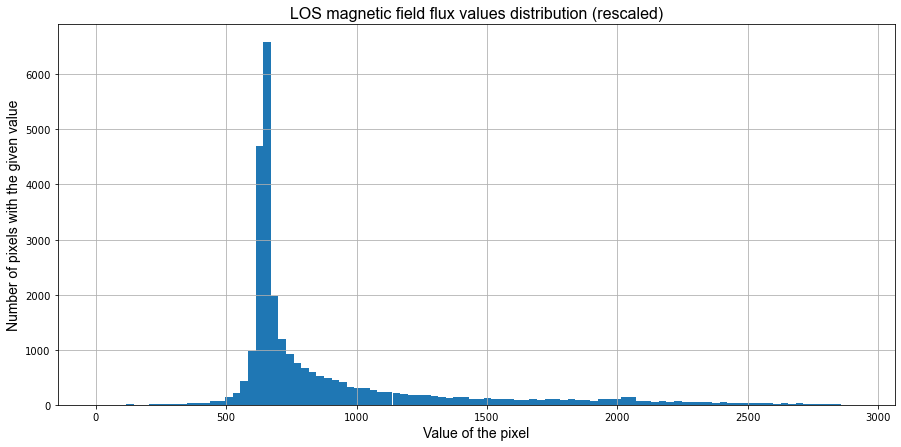

In [625]:
fig = plt.figure(figsize=(15,7))
counts, bins = np.histogram(data_2_sunspot, bins=100)
plt.hist(bins[:-1], bins,  weights=counts)
plt.xlabel("Value of the pixel", **axis_font)
plt.ylabel("Number of pixels with the given value", **axis_font)
plt.title("LOS magnetic field flux values distribution (rescaled)", **title_font)
plt.grid();

**At this point, let us apply what we learned from the histograms above in order to define thresholds and segment sunspot umbra and sunspot penumbra, there will be three areas which correspond to umbra, penumbra and the background:**

In [626]:
for k in range (0, 170):
    for j in range (0, 165):
        if (data_1_sunspot[k][j]) >= 50000:
            data_1_sunspot[k][j] = 64000
        if (data_1_sunspot[k][j]) >= 20000 and (data_1_sunspot[k][j]) < 50000:
            data_1_sunspot[k][j] = 35000
        if (data_1_sunspot[k][j]) < 20000:
            data_1_sunspot[k][j] = 0
            
for k in range (0, 170):
    for j in range (0, 165):
        if (data_2_sunspot[k][j]) >= 2000:
            data_2_sunspot[k][j] = 2200
        if (data_2_sunspot[k][j]) < 2000 and (data_2_sunspot[k][j]) >= 1000:
            data_2_sunspot[k][j] = 1500
        if (data_2_sunspot[k][j]) < 1000 :
            data_2_sunspot[k][j] = 0

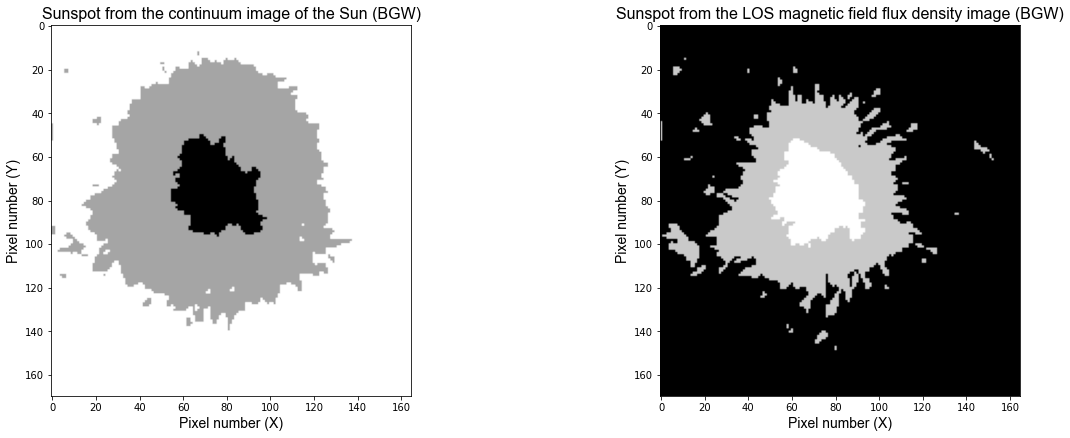

In [627]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,2,1)

ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data_1_sunspot, cmap='Greys_r', norm=colors.Normalize(vmin=0, vmax=data_1_sunspot.max()))
ax1.set_title('Sunspot from the continuum image of the Sun (BGW)', **title_font)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(data_2_sunspot, cmap='Greys_r', norm=colors.Normalize(vmin=0, vmax=data_2_sunspot.max()))
ax2.set_title('Sunspot from the LOS magnetic field flux density image (BGW)', **title_font);

**On the first image, the black region corresponds to the umbra of the sunspot, the grey region corresponds to the penumbra of the sunspot and the white region corresponds to the remaining region of the Sun. For the second image, the colors are inversed. Now, we will define the contours which correspond to the regions of interest by defining their boundary values:**

In [630]:
# Due to the fact that the fits file have some issues, there are some errors which are showed here, 
# however, they do not obstruct the implementation of the code
contours_1 = map_1_sunspot.contour(63000);
contours_2 = map_1_sunspot.contour(34000);

contours_3 = map_2_sunspot.contour(1900);
contours_4 = map_2_sunspot.contour(1400);

C:\Users\vikak\anaconda3\lib\site-packages\sunpy\map\mapbase.py:657: SunpyMetadataWarning: Could not parse unit string "DN" as a valid FITS unit.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'


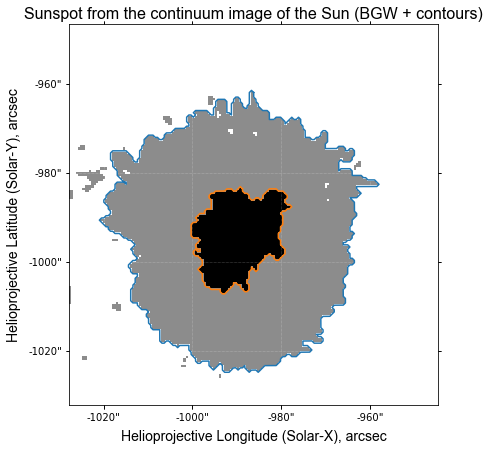

In [629]:
plt.figure(figsize=(15,7))

ax = plt.subplot(projection=map_1_sunspot)
map_1_sunspot.plot()
ax.set_xlabel('Helioprojective Longitude (Solar-X), arcsec', **axis_font)
ax.set_ylabel('Helioprojective Latitude (Solar-Y), arcsec', **axis_font)
ax.set_title('Sunspot from the continuum image of the Sun (BGW + contours)', **title_font)

for contour in contours_1:
    if len(contour) > 400:
        ax.plot_coord(contour)
for contour in contours_2:
    if len(contour) > 200:
        ax.plot_coord(contour)
plt.show()

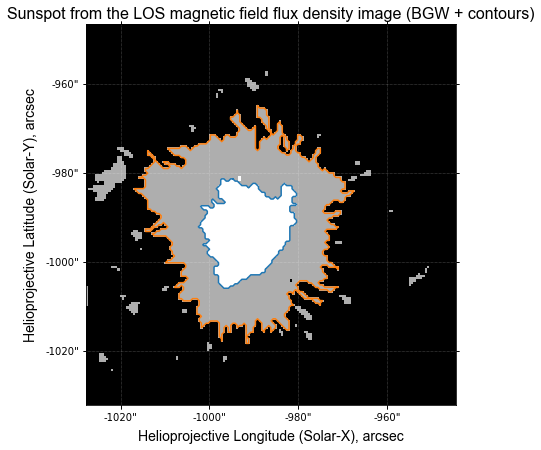

In [565]:
plt.figure(figsize=(15,7))

ax = plt.subplot(projection=map_2_sunspot)
map_2_sunspot.plot()
ax.set_xlabel('Helioprojective Longitude (Solar-X), arcsec', **axis_font)
ax.set_ylabel('Helioprojective Latitude (Solar-Y), arcsec', **axis_font)
ax.set_title('Sunspot from the LOS magnetic field flux density image (BGW + contours)', **title_font)
for contour in contours_3:
    if len(contour) > 230:
        ax.plot_coord(contour)
for contour in contours_4:
    if len(contour) > 600:
        ax.plot_coord(contour)
plt.show()

**Now, the images have the contours of the umbra and penumbra. Once the boundaries of the regions are defined, one may calculate the mean magnetic flux density for the three aforementioned regions, since the values of the pixels correspond to the values of this parameter in Gauss units:**

In [631]:
# Umbra
magn_plot = data_2[c:d, a:b] - data_2[c:d, a:b].min()

for k in range (0, 170):
    for j in range (0, 165):
        if (magn_plot[k][j]) < 2000:
            magn_plot[k][j] = 0

In [632]:
sum_values_u = np.sum(magn_plot) / np.count_nonzero(magn_plot)
print('The mean magnetic flux density for the umbra is %.0f' % (sum_values_u + data_2[c:d, a:b].min()), 'G.')

The mean magnetic flux density for the umbra is 1655 G.


In [633]:
# Penumbra
magn_plot_2 = data_2[c:d, a:b] - data_2[c:d, a:b].min()

for k in range (0, 170):
    for j in range (0, 165):
        if (magn_plot_2[k][j]) > 2000 or (magn_plot_2[k][j]) < 1000:
            magn_plot_2[k][j] = 0

In [634]:
sum_values_p = np.sum(magn_plot_2) / np.count_nonzero(magn_plot_2)
print('The mean magnetic flux density for the penumbra is %.0f' % (sum_values_p + data_2[c:d, a:b].min()) , 'G.')

The mean magnetic flux density for the penumbra is 754 G.


In [635]:
# Background
magn_plot_3 = data_2[c:d, a:b] - data_2[c:d, a:b].min()

for k in range (0, 170):
    for j in range (0, 165):
        if (magn_plot_3[k][j]) > 1000:
            magn_plot_3[k][j] = 0

In [640]:
sum_values_b = np.sum(magn_plot_3) / np.count_nonzero(magn_plot_3)
print('The mean magnetic flux density for the background is %.0f' % (sum_values_b + data_2[c:d, a:b].min()), 'G.')

The mean magnetic flux density for the background is 47 G.


**Here we notice that, as it was expected, the values for the mean magnetic fluxes are going down from the region of "epicenter" of the sunspot to the region outside it. The level of magnetic flux density for the penumbra is about two times lower than that for the umbra. The value for the outside region is significantly lower than the previous two.**

**Now, we will estimate the diameter and, thus, the area of the sunspot under study. For simplicity, we assume that the sunspot (and both umbra and penumbra) is a circle and the largest distance between the boarders of the regions corresponds to the diameter of this circle.**

In [641]:
length = []
for k in range (0, 170):
    count = 0
    for j in range (0, 165):
        if magn_plot[k][j] >= 2000:
            count += 1
        length.append(count)
        
diam_u = np.array(length).max() # pixels

In [642]:
length = []
for k in range (0, 170):
    count = 0
    for j in range (0, 165):
        if (magn_plot_2[k][j]) < 2000 and (magn_plot_2[k][j]) > 1000:
            count += 1
        length.append(count)
diam_p = np.array(length).max() # pixels

**From the given data in the FITS files, we take the value for the angular resolution per pixel and the radius of the sun in arcseconds as well as define some standard parameters like the radius of the sun and the earth.**

In [643]:
ang_resol = header_2['CDELT1']            # arcsec/pix
arcsec_sun = header_2['RSUN_OBS']         # arcsec
R_sun = 696340                            # km
R_earth = 6731                            # km

In [644]:
arcsec_sunspot = diam_p * ang_resol       # arcsec
arcsec_umbra = diam_u * ang_resol         # arcsec

In [645]:
km_per_arc = R_sun / arcsec_sun           # km/arcsec

In [646]:
D_ratio = diam_p * km_per_arc / (2*R_earth)
print('The sunspot\'s diameter is approx %.1f' % D_ratio, 'larger than the diameter of the Earth.')

The sunspot's diameter is approx 5.7 larger than the diameter of the Earth.


In [650]:
area_u = np.pi * (arcsec_umbra * km_per_arc / 2) ** 2      # km^2
area_s = np.pi * (arcsec_sunspot * km_per_arc / 2) ** 2    # km^2
area_p = area_s - area_u                                   # km^2
area_e = np.pi * R_earth ** 2                              # km^2

print('The area of the umbra is %.0f' % area_u, 'km2;')
print('The area of the penumbra is %.0f' % area_p, 'km2;')
print('The area of the sunspot is %.0f' % area_s, 'km2;')
print('The ratio of the area of the sunspot under study to the cross-sectional area of the Earth is approximately %.1f' 
      % (area_s/area_e), '.')



The area of the umbra is 188250989 km2;
The area of the penumbra is 977398320 km2;
The area of the sunspot is 1165649308 km2;
The ratio of the area of the sunspot under study to the cross-sectional area of the Earth is approximately 8.2 .


**Learning log:** In this assignment, we started working with sunspots' magnetic fields and temperature structures. Much of the work was dedicated to the processing of the images recorded by the Helioseismic Magnetic Imager (HMI) - the first image represented the continuum image of the sun, the second one showed the Line-of-Sight (LOS) magnetic field flux density for the same point of time. Firstly, it was noticed that sunspots appear darker than the ambient photosphere because they are less hot than the surrounding. Moreover, it was seen that the sunspots have a double structure with opposite magnetic polarities (it was observed better on the second picture) and the polarities are different for two hemispheres (for instance, if f (following) spot is positive and p spot (preceding) is negative for the North hemisphere, for the Southern it is vice versa). Later on, we basically chose one sunspot from the Southern hemisphere and tried to tune the subset images of this sunspot to Black-Grey-White (BGW) scheme to segment the umbra and penumbra regions from the remaining area of the Sun. Then, we used these subsets to create "masks" for the images and find contours of the regions to use them later when we calculated the mean values of magnetic flux densities for three regions. As it was expected, the values for the epicenter of the sunspot were much higher than for the other regions (twice higher than for the penumbra and ~40 higher than for the quite area of the Sun). As a result, we managed to calculate the diameter of these regions as well as their areas and compate them to the values for the Earth: sometimes one may forget about the order of the cosmic distances and sizes -  it was a surprise that this tiny sunspot is ~6 times higher in diameter and ~8 times higher in the cross-sectional area than the Earth.